# Speech Understanding 
# Lecture 13: Voice Conversion



### Mark Hasegawa-Johnson, KCGI

In today's lecture, we will learn how to convert your voice into the voice of a robot.   We'll learn how to change the robot's pitch and voice quality, to get slightly different tones of voice.

Here are the contents:
1. [Data](#data)
1. [Linear predictive coding (LPC)](#section2)
1. [LPC synthesis](#section3)
1. [Robot speech](#section4)
1. [Homework](#homework)

<a id='data'></a>

## 1. Data

To start out with, let's load an arbitrary speech waveform, and create its spectrogram.  

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import IPython.display

speech, fs = librosa.load('speech_waveform.wav', sr=8000)
IPython.display.Audio(data=speech,rate=fs)

In [40]:
frame_length = int(np.round(fs*0.025))
frame_skip = int(np.round(fs*0.01))
frames = np.array([speech[m*frame_skip:m*frame_skip+frame_length] for m in range(int((len(speech)-frame_length)/frame_skip)) ])
mstft = np.abs(np.fft.fft(frames))
sgram = 20*np.log10(np.maximum(mstft,1e-6*np.amax(mstft)))[:,:int(frame_length/2)]

Text(0.5, 1.0, 'Spectrogram')

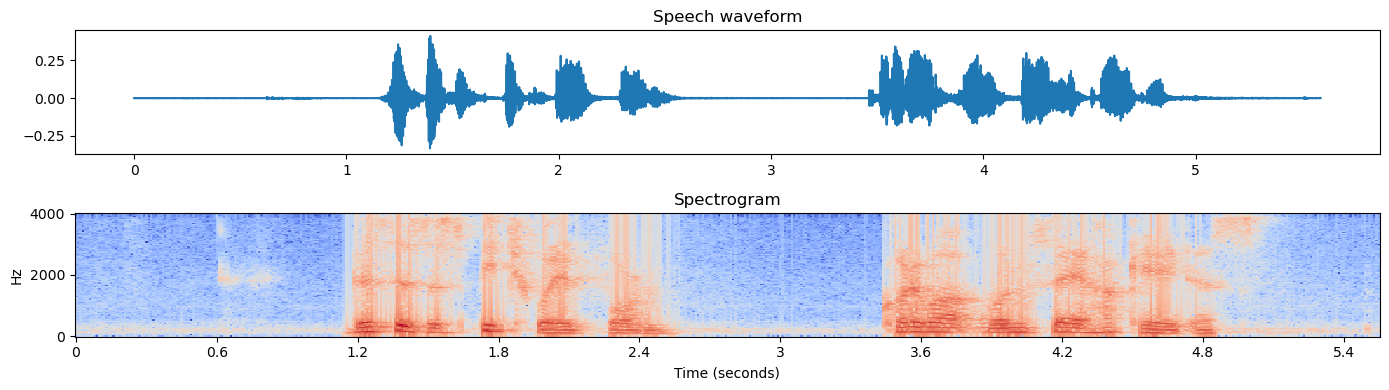

In [41]:
fig = plt.figure(figsize=(14,4),layout='tight')
ax = fig.subplots(2,1)
ax[0].plot(np.arange(len(speech))/fs,speech)
ax[0].set_title('Speech waveform')
librosa.display.specshow(sgram.transpose(),ax=ax[1],sr=fs,hop_length=frame_skip,x_axis='s',y_axis='hz')
ax[1].set_title('Spectrogram')


Text(0.5, 0, 'Frequency (Hz)')

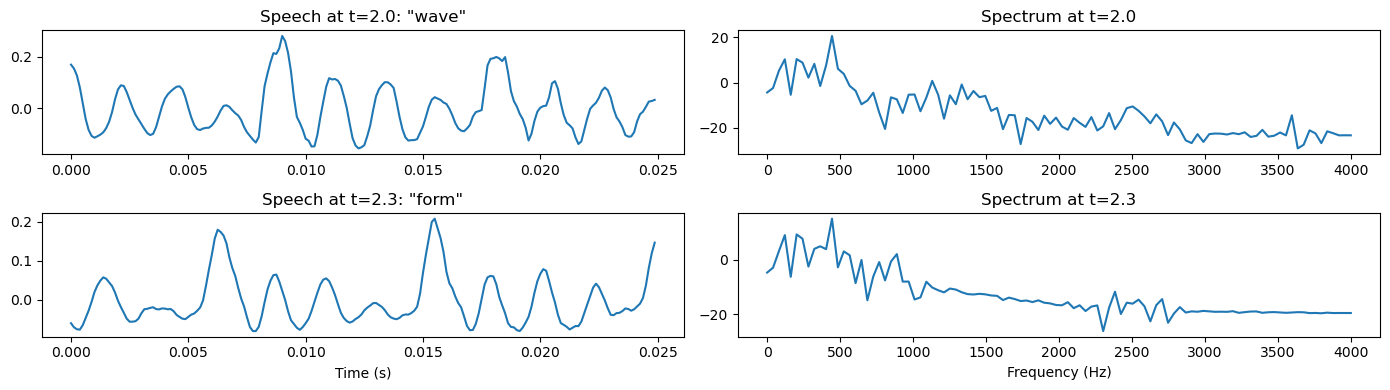

In [42]:
fig = plt.figure(figsize=(14,4),layout='tight')
ax = fig.subplots(2,2)
ax[0,0].plot(np.arange(frame_length)/fs,frames[200])
ax[0,0].set_title('Speech at t=2.0: "wave"')
ax[0,1].plot(np.linspace(0,fs/2,int(frame_length/2)),sgram[200])
ax[0,1].set_title('Spectrum at t=2.0')
ax[1,0].plot(np.arange(frame_length)/fs,frames[230])
ax[1,0].set_title('Speech at t=2.3: "form"')
ax[1,0].set_xlabel('Time (s)')
ax[1,1].plot(np.linspace(0,fs/2,int(frame_length/2)),sgram[230])
ax[1,1].set_title('Spectrum at t=2.3')
ax[1,1].set_xlabel('Frequency (Hz)')

<a id='section2'></a>

## 2.  Linear Predictive Coding (LPC)

Remember that, last lecture, we learned that steady-state vowels can be synthesized by passing an excitation signal, $e[n]$, through a series of resonant filters like this:

$$e[n]\rightarrow
\fbox{$\stackrel{F_1}{\text{resonator}}$}\rightarrow
\fbox{$\stackrel{F_2}{\text{resonator}}$}\rightarrow
\fbox{$\stackrel{F_3}{\text{resonator}}$}\rightarrow
\fbox{$\stackrel{F_4}{\text{resonator}}$}\rightarrow s[n]$$

* The excitation signal, $e[n]$, has one impulse per pitch period
* The resonators compute feedback, $y[n]=e[n]+a[1]y[n-1]+a[2]y[n-2]$.

This week, instead of computing resonator coefficients from knowledge about speech production, we will compute them by analyzing a real speech signal.  That will be easier if we group all $4\times 2=8$ of the coefficients into a single equation. Just to make sure we have enough modeling power, we'll use 10 feedback loops:

$$s[n]=e[n]-\sum_{k=1}^{10} a[k] s[n-k]$$

$$e[n]\rightarrow
\fbox{Order-10 Resonator}\rightarrow
 s[n]$$

The coefficients $a_k$ are called a **linear predictive code (LPC)** because they code all of the information about the resonant frequencies of the speech. For each frame, they can be computed using the function <a href="https://librosa.org/doc/0.11.0/generated/librosa.lpc.html">librosa.lpc</a>.

Text(0.5, 0, 'Time (samples)')

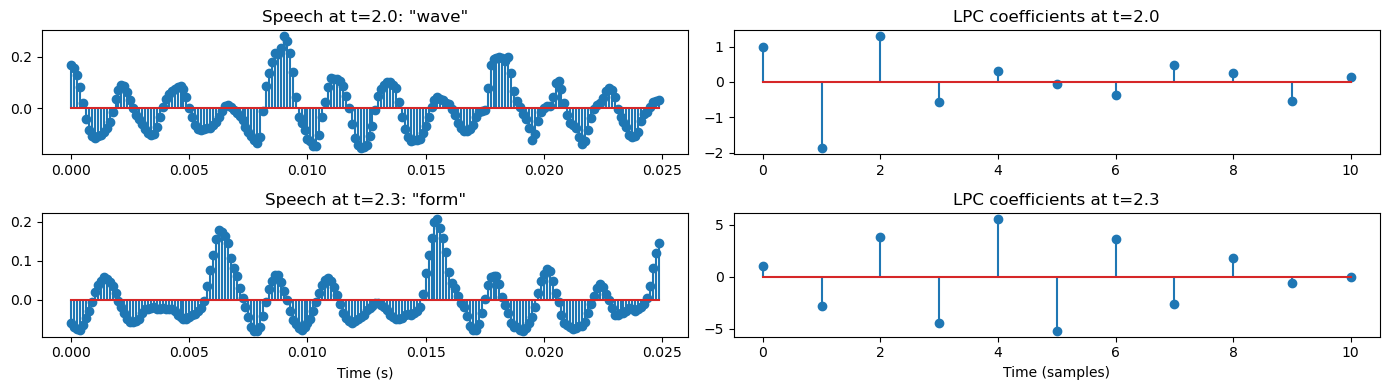

In [43]:
A = librosa.lpc(frames,order=10)

fig = plt.figure(figsize=(14,4),layout='tight')
ax = fig.subplots(2,2)
ax[0,0].stem(np.arange(frame_length)/fs,frames[200])
ax[0,0].set_title('Speech at t=2.0: "wave"')
ax[0,1].stem(A[200])
ax[0,1].set_title('LPC coefficients at t=2.0')
ax[1,0].stem(np.arange(frame_length)/fs,frames[230])
ax[1,0].set_title('Speech at t=2.3: "form"')
ax[1,0].set_xlabel('Time (s)')
ax[1,1].stem(A[230])
ax[1,1].set_title('LPC coefficients at t=2.3')
ax[1,1].set_xlabel('Time (samples)')

The LPC coefficients by themselves are not very useful, but they can be used for many useful things. For example, we can find the excitation by subtracting the predicted speech, $\sum_{k=1}^{10}a[k]s[n-k]$, from the original speech:

$$e[n] = s[n] + \sum_{k=1}^{10}a[k] s[n-k]$$

`librosa.lpc`, by default, sets $a[0]=1$ in each frame, so we can write the above equation as

$$e[n] = \sum_{k=0}^{10}a[k] s[n-k]$$


In [44]:
nframes, nsamps = frames.shape
excitation = np.zeros((nframes,nsamps))
for frame in range(nframes):
    for samp in range(10,nsamps):
        for k in range(11):
            excitation[frame,samp] += A[frame,k]*frames[frame,samp-k]

Text(0.5, 0, 'Time (seconds)')

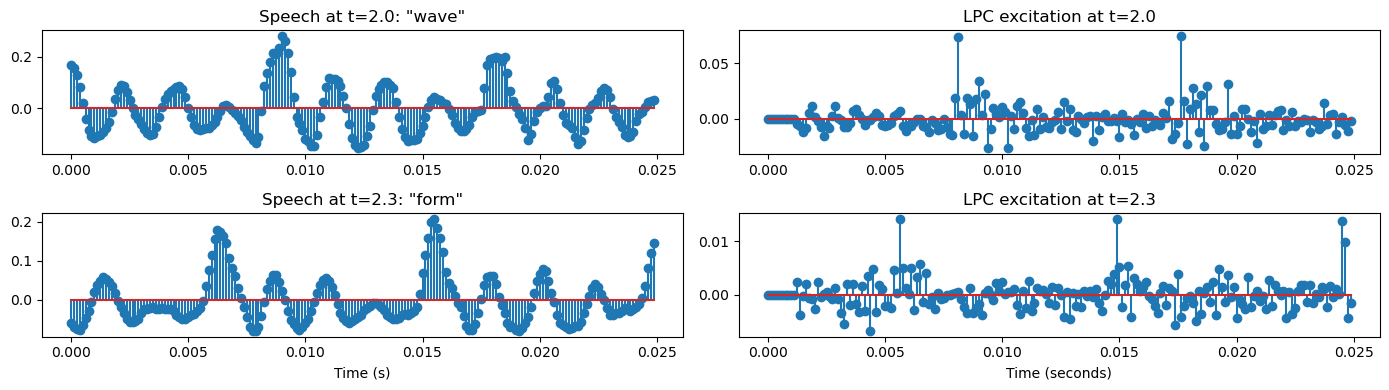

In [46]:
fig = plt.figure(figsize=(14,4),layout='tight')
ax = fig.subplots(2,2)
ax[0,0].stem(np.arange(frame_length)/fs,frames[200])
ax[0,0].set_title('Speech at t=2.0: "wave"')
ax[0,1].stem(np.arange(frame_length)/fs,excitation[200])
ax[0,1].set_title('LPC excitation at t=2.0')
ax[1,0].stem(np.arange(frame_length)/fs,frames[230])
ax[1,0].set_title('Speech at t=2.3: "form"')
ax[1,0].set_xlabel('Time (s)')
ax[1,1].stem(np.arange(frame_length)/fs,excitation[230])
ax[1,1].set_title('LPC excitation at t=2.3')
ax[1,1].set_xlabel('Time (seconds)')

Notice two things about the excitation:

1. It's almost an impulse train!  This is voiced speech, so the excitation looks a lot like an impulse train.
2. Different frames have different energy.

Because filtering with LPC changes $x[n]$ into $e[n]$, we can think of the LPC coefficients as the **inverse** of $x[n]$, in the following sense:

$$G = \sqrt{\frac{1}{N}\sum_{n=0}^{N-1} e^2[n]}$$

$$|S(\omega)| \approx \frac{G}{|A(\omega)|}$$

where $A(\omega)=\mathbf{FFT}(a[n])$ and $S(\omega)=\mathbf{FFT}(x[n])$.



In [49]:
gain = np.sqrt(np.average(np.square(excitation), axis=1))
lpc_sgram = np.zeros((nframes,int(nsamps/2)))
for frame in range(nframes):
    lpc_sgram[frame,:] = 20*np.log10(gain[frame] / np.abs(np.fft.fft(A[frame,:], n=nsamps)))[:int(nsamps/2)]
    

Text(0.5, 1.0, 'LPC Spectrogram')

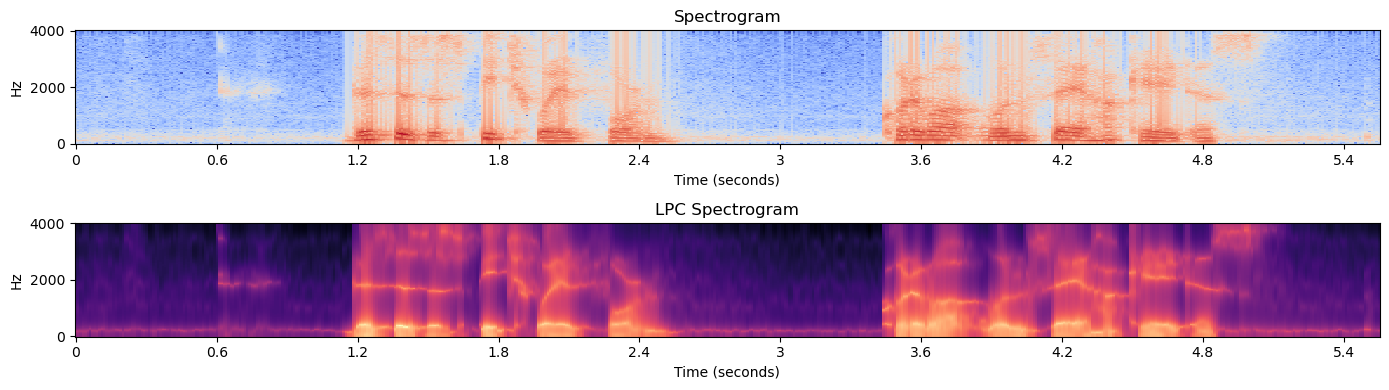

In [48]:
fig = plt.figure(figsize=(14,4),layout='tight')
ax = fig.subplots(2,1)
librosa.display.specshow(sgram.transpose(),ax=ax[0],sr=fs,hop_length=frame_skip,x_axis='s',y_axis='hz')
ax[0].set_title('Spectrogram')
librosa.display.specshow(lpc_sgram.transpose(),ax=ax[1],sr=fs,hop_length=frame_skip,x_axis='s',y_axis='hz')
ax[1].set_title('LPC Spectrogram')


<a id='section3'></a>

## 3. LPC synthesis

To synthesize speech again, we just need to create an excitation signal, and then pass it through the resonator:

$$e[n]\rightarrow\fbox{Resonant Filter}\rightarrow s[n]$$

$$s[n] = e[n] - \sum_{k=1}^{10} a[k]x[n-k]$$

To get the excitation signal, we need to be careful. When we computed `excitation`, before, we used overlapping frames, so we need to:

1. Delete the overlapping part from each frame (keep only the last `frame_skip` samples), then
1. concatenate the frames.  We can do this using <a href="https://numpy.org/doc/stable/reference/generated/numpy.hstack.html">np.hstack</a>.


In [30]:
e = np.hstack(excitation[:,(frame_length-frame_skip):frame_length])
print('There are %d frames, with a skip of %d samples, total length is %d'%(nframes,frame_skip,len(e)))

There are 556 frames, with a skip of 80 samples, total length is 44480


Now we need to use the synthesis equation.  For each speech sample, $s[n]$, we want to look up the corresponding frame number, which should be `int(n/frame_skip)`.

In [31]:
synthesis = np.zeros(len(e))
for n in range(len(e)):
    frame = int(n/frame_skip)
    synthesis[n] = e[n]
    for k in range(1,min(n,11)):
        synthesis[n] -= A[frame,k] * synthesis[n-k]

IPython.display.Audio(data=synthesis, rate=fs)

Text(0.5, 1.0, 'Synthesized Spectrogram')

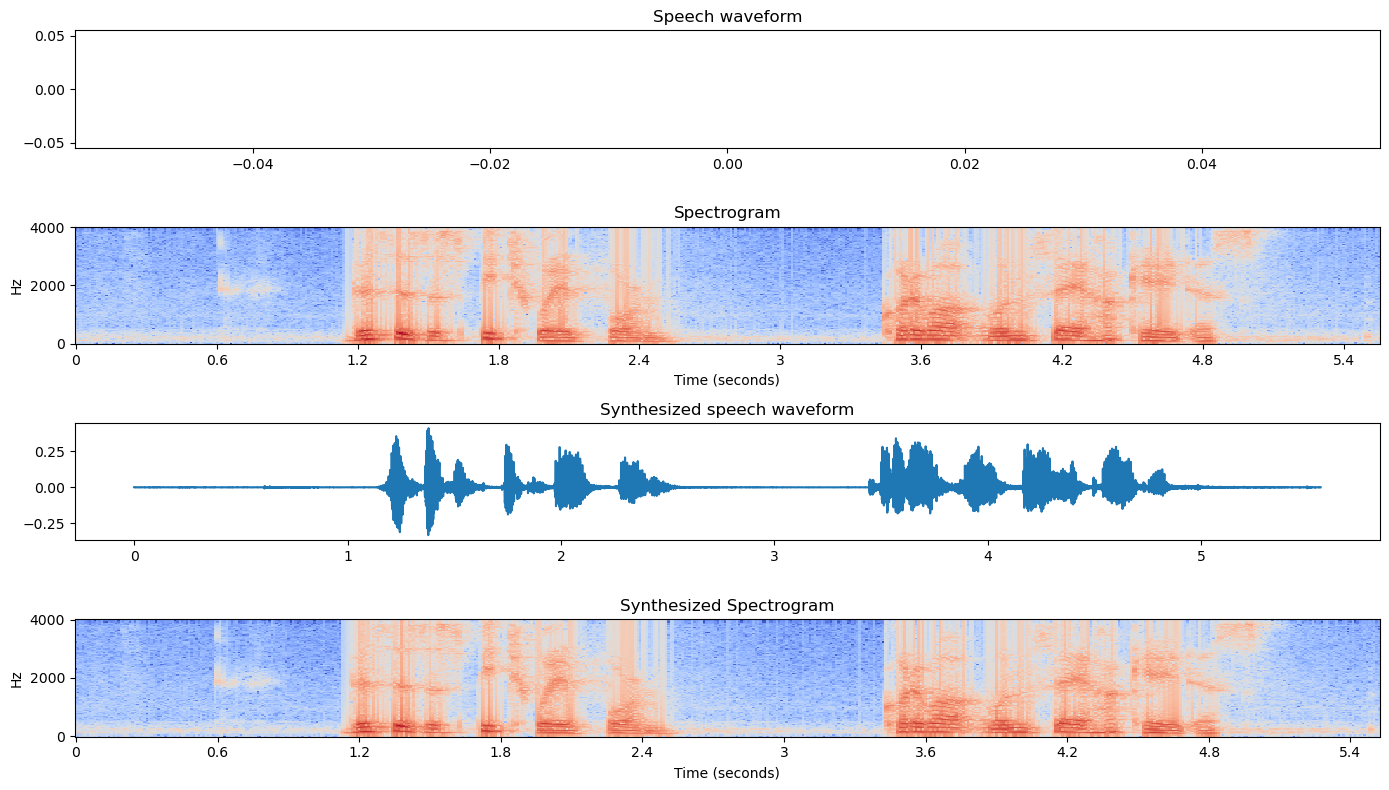

In [32]:
synth_frames = np.array([synthesis[m*frame_skip:m*frame_skip+frame_length] for m in range(int((len(synthesis)-frame_length)/frame_skip)) ])
synth_mstft = np.abs(np.fft.fft(synth_frames))
synth_sgram = 20*np.log10(np.maximum(synth_mstft,1e-6*np.amax(synth_mstft)))[:,:int(frame_length/2)]
fig = plt.figure(figsize=(14,8),layout='tight')
ax = fig.subplots(4,1)
ax[0].plot(np.arange(len(speech))/fs,speech)
ax[0].set_title('Speech waveform')
librosa.display.specshow(sgram.transpose(),ax=ax[1],sr=fs,hop_length=frame_skip,x_axis='s',y_axis='hz')
ax[1].set_title('Spectrogram')
ax[2].plot(np.arange(len(synthesis))/fs,synthesis)
ax[2].set_title('Synthesized speech waveform')
librosa.display.specshow(synth_sgram.transpose(),ax=ax[3],sr=fs,hop_length=frame_skip,x_axis='s',y_axis='hz')
ax[3].set_title('Synthesized Spectrogram')


<a id='section4'></a>

## 4. Robot speech

Now that we know how to resynthesize speech, let's modify it so it sounds like a robot.

* Change the excitation so it's a perfect monotone, always exactly $F_0=100$Hz.
* Change the excitation so it's perfectly voiced, with no breathiness.

We can do this by setting $e_{\text{robot}}[n]=G p[n]$, where $p[n]$ is an impulse train, and $G$ is the excitation gain in each frame.



In [33]:
p, e_robot, s_robot = np.zeros(len(e)), np.zeros(len(e)), np.zeros(len(e))

p[::int(fs/100)] = 1

for n in range(len(p)):
    frame = int(n/frame_skip)
    e_robot[n] = gain[frame] * p[n]
    s_robot[n] = e_robot[n]
    for k in range(1,min(n,11)):
        s_robot[n] -= A[frame,k] * s_robot[n-k]

IPython.display.Audio(data=s_robot, rate=fs)

Let's make it a female robot!  We can do that by setting $F_0$ to a value that sounds female, for example, $F_0=200$Hz.



In [34]:
p, e_robot, s_robot = np.zeros(len(e)), np.zeros(len(e)), np.zeros(len(e))

p[::int(fs/200)] = 1

for n in range(len(p)):
    frame = int(n/frame_skip)
    e_robot[n] = gain[frame] * p[n]
    s_robot[n] = e_robot[n]
    for k in range(1,min(n,11)):
        s_robot[n] -= A[frame,k] * s_robot[n-k]

IPython.display.Audio(data=s_robot, rate=fs)

As you can imagine, there are lots of other modifications we can make.  For example, let's make the pitch frequency rise for the first half, then fall for the second half:

$$F_0(t) =\min\left(200+40t,400-40t\right)$$


Text(0.5, 1.0, 'T0 in samples')

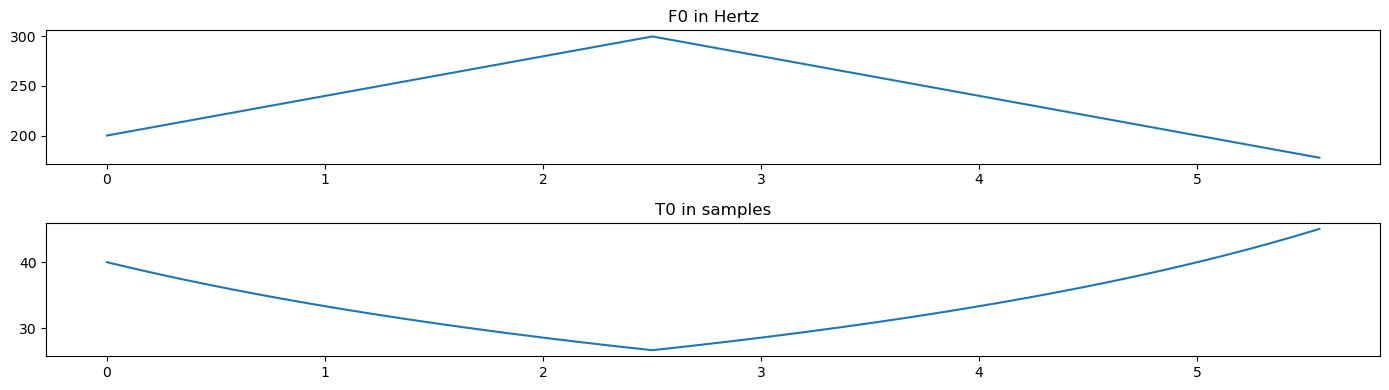

In [35]:
t = np.arange(len(e))/fs
F0 = np.minimum(200+40*t,400-40*t)
T0 = fs/F0

fig = plt.figure(figsize=(14,4),layout='tight')
ax = fig.subplots(2,1)
ax[0].plot(np.arange(len(F0))/fs,F0)
ax[0].set_title('F0 in Hertz')
ax[1].plot(np.arange(len(T0))/fs,T0)
ax[1].set_title('T0 in samples')

Text(0.5, 1.0, 'Robot excitation in the frame at t=2.3s.  Notice: The pitch period is shorter here!')

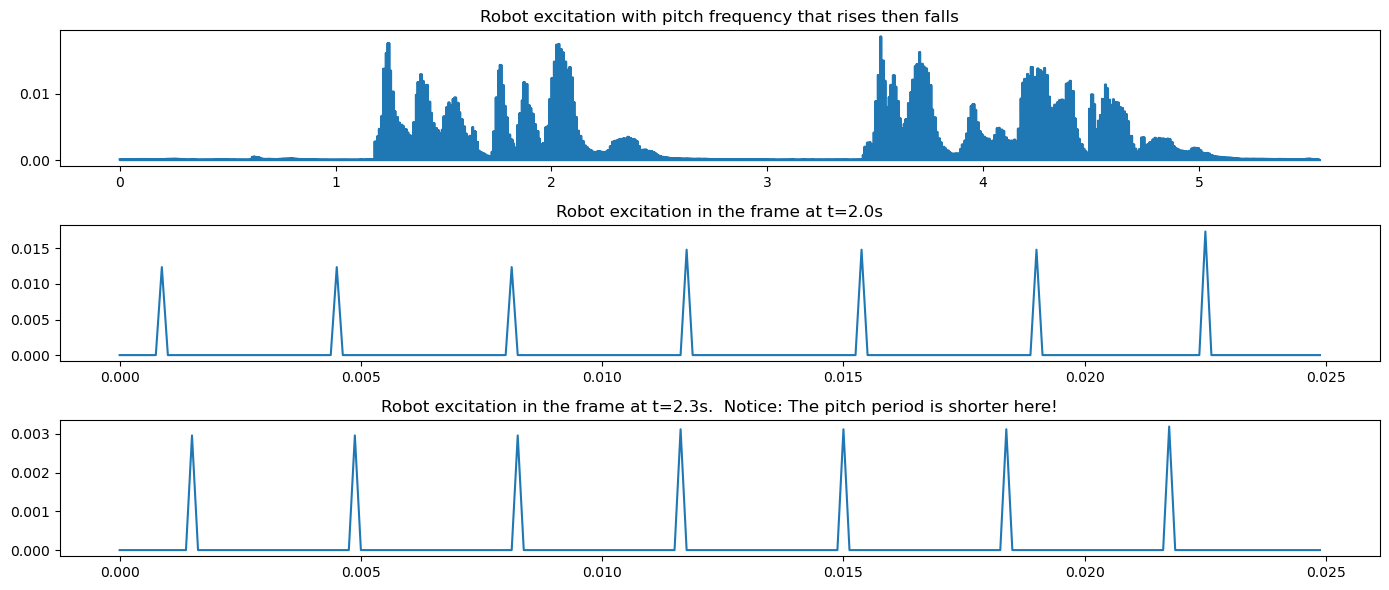

In [36]:
e_robot = np.zeros(len(e))
n = 0
while n < len(e_robot):
    e_robot[n] = gain[int(n/frame_skip)]
    n += int(np.round(T0[n]))
fig = plt.figure(figsize=(14,6),layout='tight')
ax = fig.subplots(3,1)
ax[0].plot(np.arange(len(e_robot))/fs,e_robot)
ax[0].set_title('Robot excitation with pitch frequency that rises then falls')
ax[1].plot(np.arange(frame_length)/fs,e_robot[2*fs:2*fs+frame_length])
ax[1].set_title('Robot excitation in the frame at t=2.0s')
ax[2].plot(np.arange(frame_length)/fs,e_robot[int(2.3*fs):int(2.3*fs)+frame_length])
ax[2].set_title('Robot excitation in the frame at t=2.3s.  Notice: The pitch period is shorter here!')


In [37]:
for n in range(len(p)):
    s_robot[n] = e_robot[n]
    for k in range(1,min(n,11)):
        s_robot[n] -= A[int(n/frame_skip),k] * s_robot[n-k]

IPython.display.Audio(data=s_robot, rate=fs)

<a id="homework"></a>

## Homework 

Homework will be graded on Github.com.  Edit the following functions:

### Homework 13.1: lpc

In [38]:
import homework13, importlib
importlib.reload(homework13)
help(homework13.lpc)

Help on function lpc in module homework13:

lpc(speech, frame_length, frame_skip, order)
    Perform linear predictive analysis of input speech.

    @param:
    speech (duration) - input speech waveform
    frame_length (scalar) - frame length, in samples
    frame_skip (scalar) - frame skip, in samples
    order (scalar) - number of LPC coefficients to compute

    @returns:
    A (nframes,order+1) - linear predictive coefficients from each frames
    excitation (nframes,frame_length) - linear prediction excitation frames
      (only the last frame_skip samples in each frame need to be valid)



Text(0.5, 1.0, 'LPC Spectrogram')

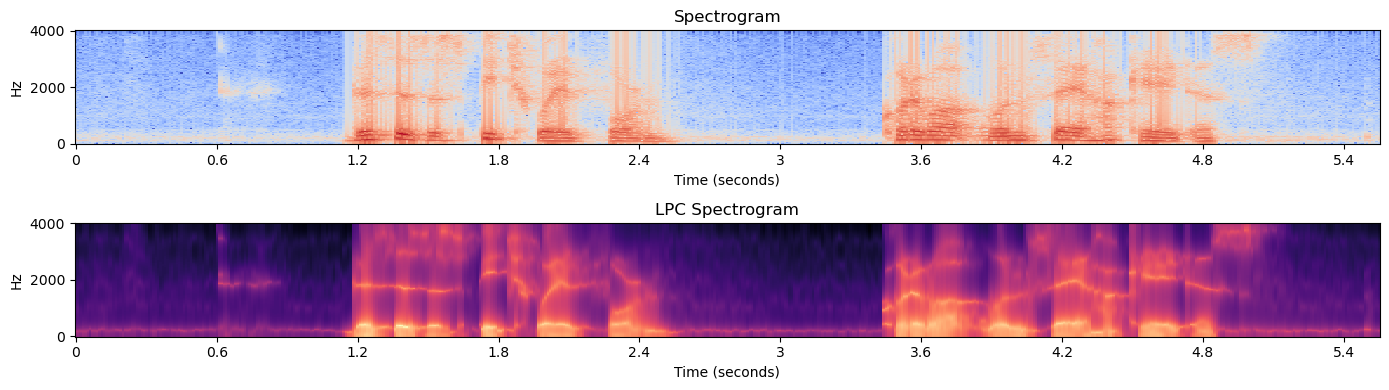

In [52]:
importlib.reload(homework13)
A, excitation = homework13.lpc(speech, frame_length, frame_skip, 10)

gain = np.sqrt(np.average(np.square(excitation), axis=1))
lpc_sgram = np.zeros((nframes,int(nsamps/2)))
for frame in range(nframes):
    lpc_sgram[frame,:] = 20*np.log10(gain[frame] / np.abs(np.fft.fft(A[frame,:], n=nsamps)))[:int(nsamps/2)]
fig = plt.figure(figsize=(14,4),layout='tight')
ax = fig.subplots(2,1)
librosa.display.specshow(sgram.transpose(),ax=ax[0],sr=fs,hop_length=frame_skip,x_axis='s',y_axis='hz')
ax[0].set_title('Spectrogram')
librosa.display.specshow(lpc_sgram.transpose(),ax=ax[1],sr=fs,hop_length=frame_skip,x_axis='s',y_axis='hz')
ax[1].set_title('LPC Spectrogram')


### Homework 12.3: synthesize

In [53]:
importlib.reload(homework13)
help(homework13.synthesize)

Help on function synthesize in module homework13:

synthesize(e, A, frame_skip)
    Synthesize speech from LPC residual and coefficients.

    @param:
    e (duration) - excitation signal
    A (nframes,order+1) - linear predictive coefficients from each frames
    frame_skip (1) - frame skip, in samples

    @returns:
    synthesis (duration) - synthetic speech waveform



In [55]:
importlib.reload(homework13)

e = np.hstack(excitation[:,(frame_length-frame_skip):frame_length])
synthesis = homework13.synthesize(e, A, frame_skip)

IPython.display.Audio(data=synthesis, rate=fs)

### Homework 13.3: robot voice

In [58]:
importlib.reload(homework13)
help(homework13.robot_voice)

Help on function robot_voice in module homework13:

robot_voice(excitation, T0, frame_skip)
    Calculate the gain for each excitation frame, then create the excitation for a robot voice.

    @param:
    excitation (nframes,frame_length) - linear prediction excitation frames
    T0 (scalar) - pitch period, in samples
    frame_skip (scalar) - frame skip, in samples

    @returns:
    gain (nframes) - gain for each frame
    e_robot (nframes*frame_skip) - excitation for the robot voice



In [59]:
importlib.reload(homework13)

gain, e_robot = homework13.robot_voice(excitation, int(fs/100), frame_skip)
s_robot = homework13.synthesize(e_robot, A, frame_skip)

IPython.display.Audio(data=s_robot, rate=fs)

### Receiving your grade

In order to receive a grade for your homework, you need to:

1. Run the following code block on your machine.  The result may list some errors, and then in the very last line, it will show a score.  That score (between 0% and 100%) is the grade you have earned so far.  If you want to earn a higher grade, please continue editing `homework3.py`, and then run this code block again.
1. When you are happy with your score (e.g., when it reaches 100%), choose `File` $\Rightarrow$ `Save and Checkpoint`.  Then use `GitHub Desktop` to commit and push your changes.
1. Make sure that the 100% shows on your github repo on github.com.  If it doesn't, you will not receive credit.

In [61]:
import importlib, grade
importlib.reload(grade)

..E
ERROR: test_synthesize (grade.Test.test_synthesize)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "/Users/jhasegaw/Dropbox/mark/teaching/kcgi/intro_speech_understanding/lec13/grade.py", line 31, in test_synthesize
    self.assertGreater(np.average(np.square(synthesis)),np.square(np.abs(e)),
  File "/opt/anaconda3/lib/python3.12/unittest/case.py", line 1267, in assertGreater
    if not a > b:
           ^^^^^
ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

----------------------------------------------------------------------
Ran 3 tests in 3.154s

FAILED (errors=1)


2 successes out of 3 tests run
Score: 66%


<module 'grade' from '/Users/jhasegaw/Dropbox/mark/teaching/kcgi/intro_speech_understanding/lec13/grade.py'>